# Cartpole Playground

### Import Packages

In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

### Create and reset the environment

In [2]:
# Create the environment
env = gym.make("CartPole-v1") #, render_mode="human")
test_env = gym.make("CartPole-v1")
state, info = env.reset()

SEED = 1234

np.random.seed(SEED);
torch.manual_seed(SEED);

# Get the state and action sizes
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

### Create the policy network

In [3]:
# Define the policy function (neural network)
class Policy(nn.Module):
    def __init__(self, use_activation = True):
        super(Policy, self).__init__()
        
        # Policy activation and dropout
        self.use_activation = use_activation
        
        # Define paramaeters for layers
        self.num_hidden_layers = 1
        self.dimensions = [state_size, 128, action_size]
        
        # Define layers
        self.layers = nn.ModuleList()
        for i in range(self.num_hidden_layers):
            # Linear layer
            self.layers.append(nn.Linear(self.dimensions[i], self.dimensions[i+1]))
            # Activation layer
            if self.use_activation:
                self.layers.append(nn.ReLU())
        # Output layer
        self.layers.append(nn.Linear(self.dimensions[-2], self.dimensions[-1]))
        
    # Forward pass of the policy
    def forward(self, x):
        
        for idx, layer in enumerate(self.layers):
            x = layer(x)
            
        # Softmax to get probs
        return torch.softmax(x, dim=-1)

# Option to initialize under the glorot distribution
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0.001)

### Make the training graph

<IPython.core.display.Javascript object>


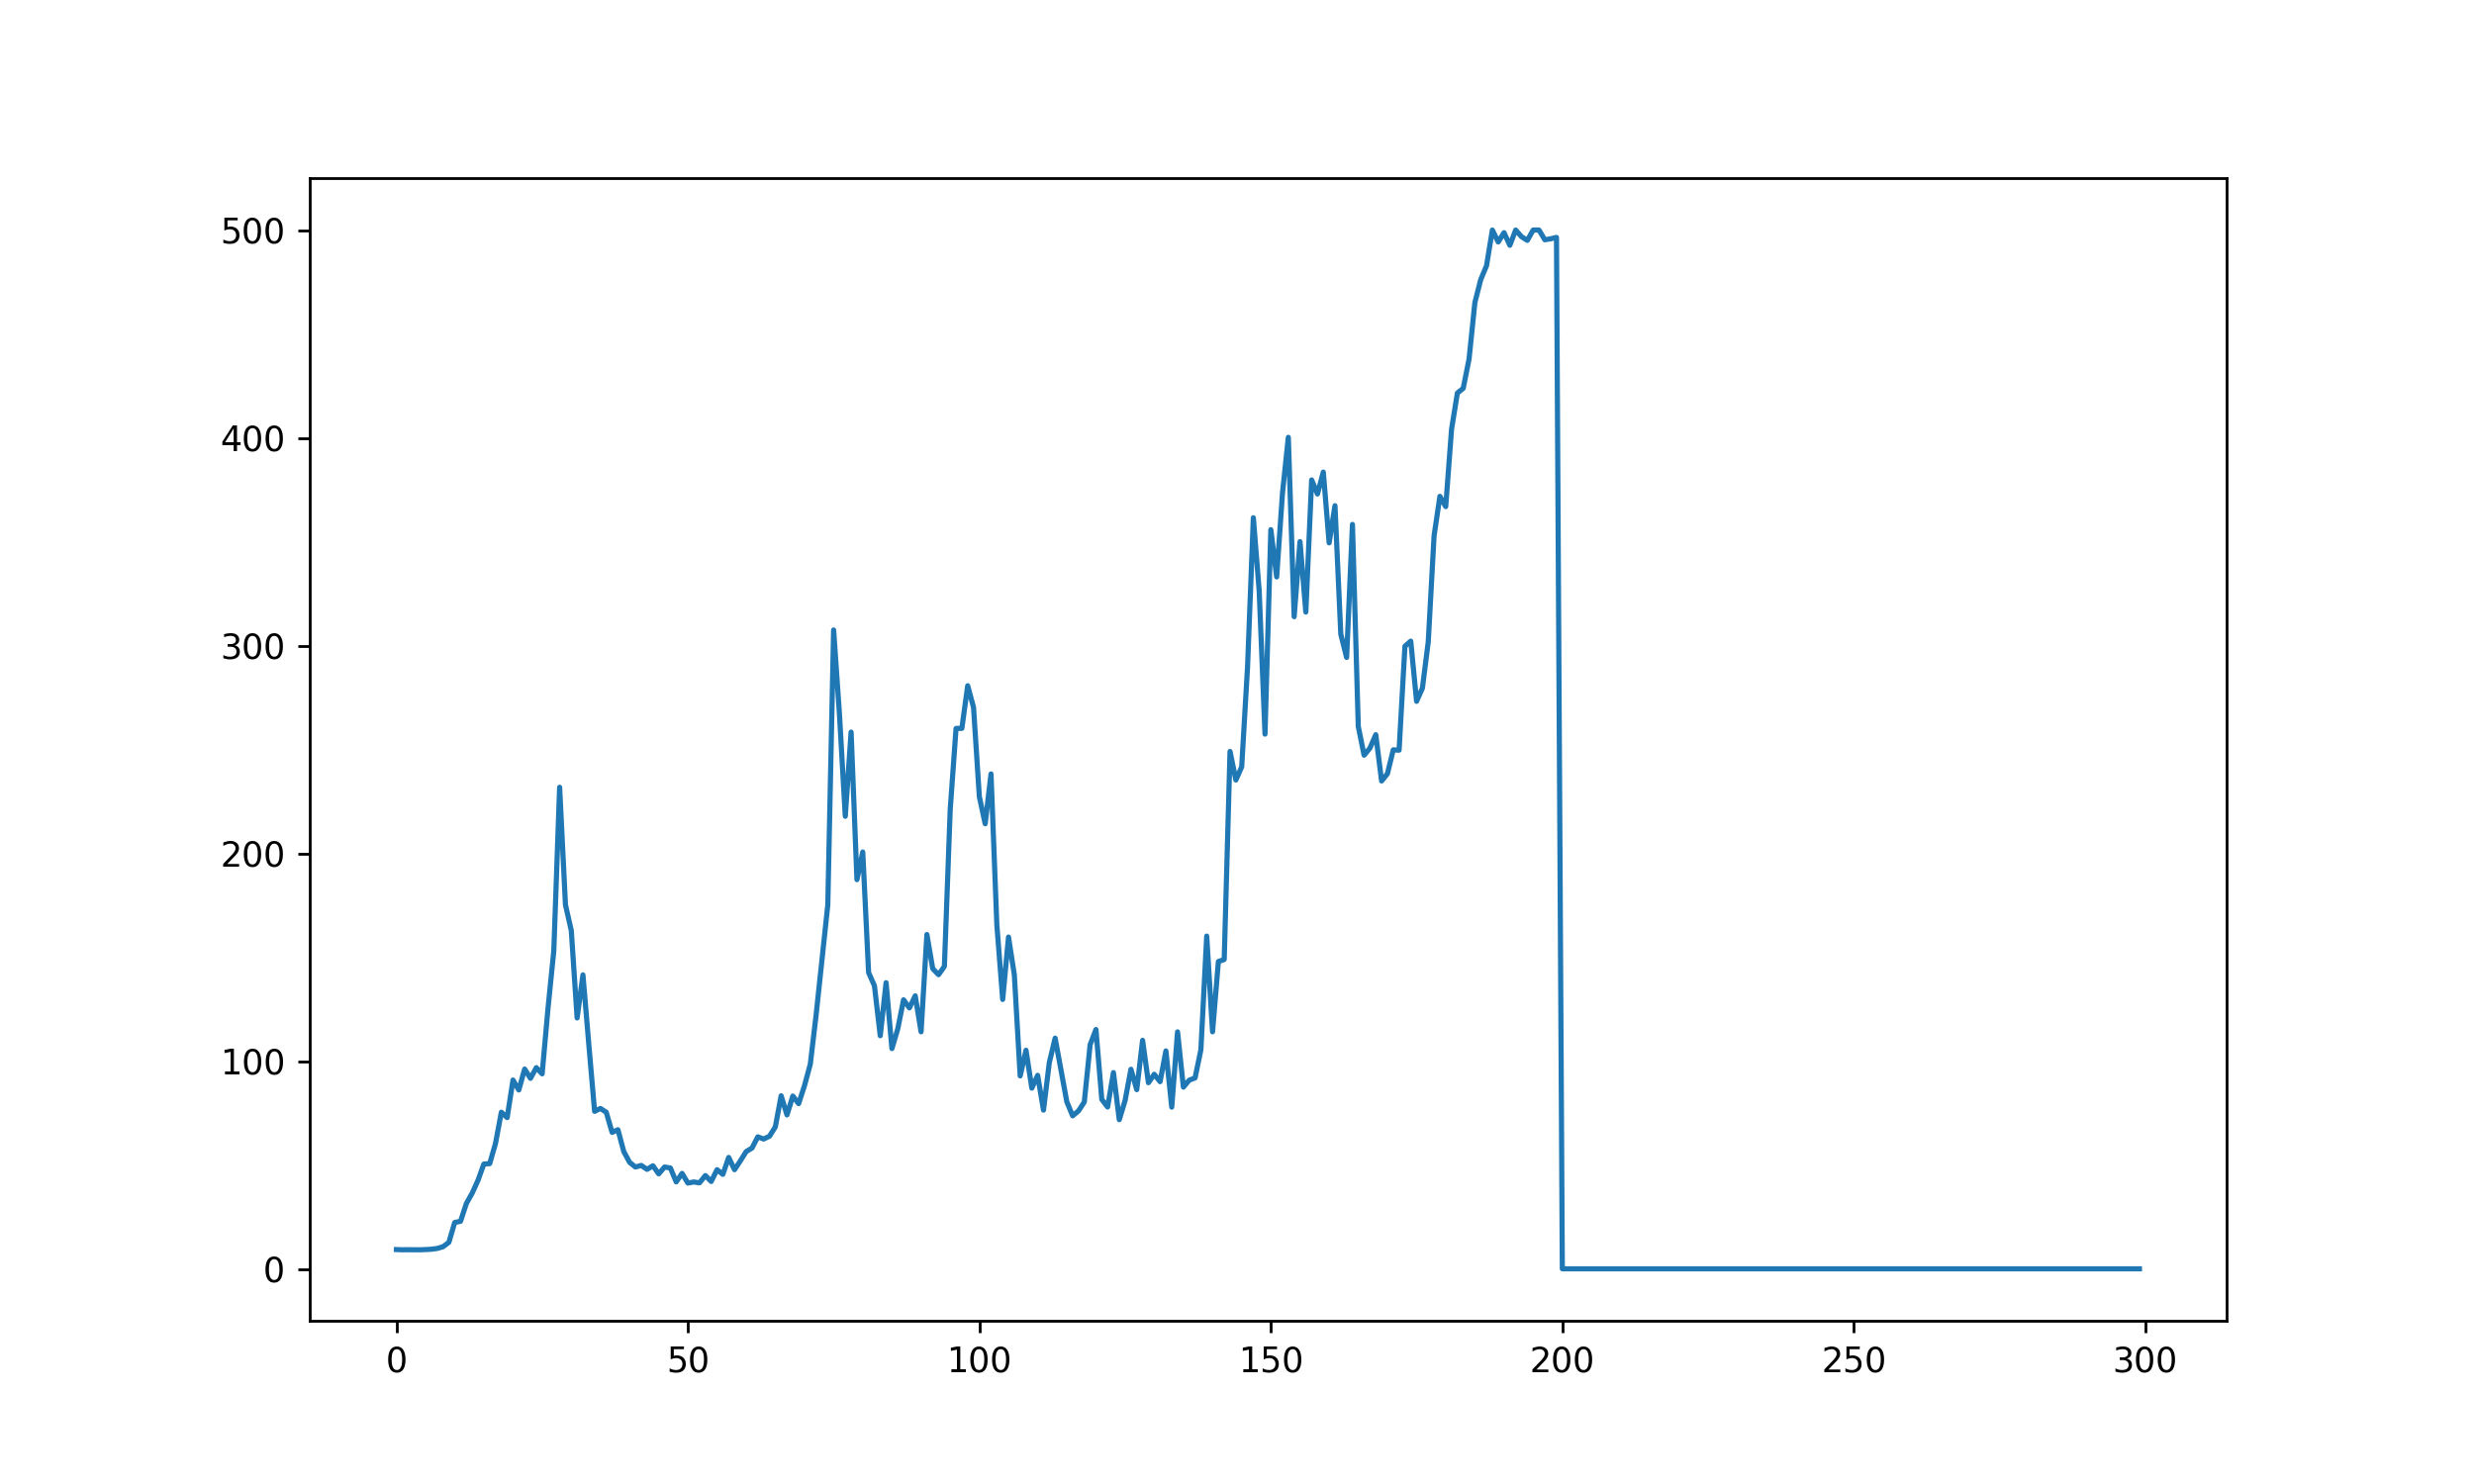

Text(0, 0.5, 'Rewards')

In [4]:
%matplotlib notebook
import matplotlib.pyplot as plt

max_episodes = 300

idxs = range(max_episodes)
fig, ax = plt.subplots(1, figsize=(10,6))
ax.set_xlabel('Steps')
ax.set_ylabel('Rewards')

### Import the necessary functions and train the policy network

In [5]:
from reinforce import *
from rl_functions import * 
import tqdm

# Configure parameters
n_runs = 1
print_every= 20
window_size = 25
train_batch_size = 5
test_batch_size = 30
max_eps_length = 500
normalize = True
reward_threshold = 400
discount_factor = 0.99

# Initialize reward storage points
train_rewards = torch.zeros(n_runs, max_episodes)
test_rewards = torch.zeros(n_runs, max_episodes)
losses = torch.zeros(n_runs, max_episodes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train policy using Reinforce with 0 baseline
for run in range(n_runs):
    
    policy = Policy()
    policy = policy.to(device)

    optimizer = optim.Adam(policy.parameters(), lr=1e-3)
    
    for episode in tqdm.tqdm(range(max_episodes), desc=f'Run: {run}'):
        
        loss, train_reward = train(env, policy, optimizer, update_policy_reinforce_static_baseline, normalize, 
                                   max_eps_length, discount_factor, train_batch_size, device)
        
        test_reward = evaluate(test_env, policy, max_eps_length, test_batch_size, device)
        
        train_rewards[run][episode] = train_reward
        test_rewards[run][episode] = test_reward
        losses[run][episode] = loss
        
        if episode % print_every == 0:
            mean_train_rewards = torch.mean(train_rewards[run, max(0,episode-window_size):episode+1])
            mean_test_rewards = torch.mean(test_rewards[run, max(0,episode-window_size):episode+1])
            mean_losses = torch.mean(losses[run, max(0,episode-window_size):episode+1])
        
            print(f'| Episode: {episode:3} | Mean Train Rewards: {mean_train_rewards:5.1f} ',
                  f'| Mean Test Rewards: {mean_test_rewards:5.1f} | Mean Losses: {mean_losses:5.1f} |')
        
        if (mean_test_rewards>reward_threshold):
            
            print(f'Reached reward threshold in {episode} episodes')
            torch.save(policy, "VPG_128_1e3_unnorm.pth") # Save best model
            break
            
        ax.clear()
        ax.plot(idxs, test_rewards[:run+1, :].mean(0))
        ax.fill_between(idxs, test_rewards.min(0).values, test_rewards.max(0).values, alpha=0.1)
        
        fig.canvas.draw()

Run: 0:   0%|▏                                                                         | 1/300 [00:00<01:02,  4.78it/s]

| Episode:   0 | Mean Train Rewards:  24.2  | Mean Test Rewards:   9.3 | Mean Losses:   0.1 |


Run: 0:   7%|█████                                                                    | 21/300 [00:04<01:18,  3.55it/s]

| Episode:  20 | Mean Train Rewards:  22.7  | Mean Test Rewards:  31.1 | Mean Losses:  -0.0 |


Run: 0:  14%|█████████▉                                                               | 41/300 [00:11<01:12,  3.57it/s]

| Episode:  40 | Mean Train Rewards:  22.6  | Mean Test Rewards:  98.2 | Mean Losses:  -0.1 |


Run: 0:  20%|██████████████▊                                                          | 61/300 [00:16<01:02,  3.81it/s]

| Episode:  60 | Mean Train Rewards:  27.0  | Mean Test Rewards:  51.3 | Mean Losses:  -0.2 |


Run: 0:  27%|███████████████████▋                                                     | 81/300 [00:25<02:19,  1.57it/s]

| Episode:  80 | Mean Train Rewards:  30.4  | Mean Test Rewards: 115.8 | Mean Losses:  -0.3 |


Run: 0:  34%|████████████████████████▏                                               | 101/300 [00:36<02:22,  1.40it/s]

| Episode: 100 | Mean Train Rewards:  35.4  | Mean Test Rewards: 184.7 | Mean Losses:  -0.5 |


Run: 0:  40%|█████████████████████████████                                           | 121/300 [00:45<01:15,  2.38it/s]

| Episode: 120 | Mean Train Rewards:  41.0  | Mean Test Rewards: 148.5 | Mean Losses:  -0.6 |


Run: 0:  47%|█████████████████████████████████▊                                      | 141/300 [00:53<01:14,  2.12it/s]

| Episode: 140 | Mean Train Rewards:  42.6  | Mean Test Rewards:  94.3 | Mean Losses:  -0.4 |


Run: 0:  54%|██████████████████████████████████████▋                                 | 161/300 [01:10<02:13,  1.04it/s]

| Episode: 160 | Mean Train Rewards:  46.4  | Mean Test Rewards: 262.9 | Mean Losses:  -0.5 |


Run: 0:  60%|███████████████████████████████████████████▍                            | 181/300 [01:28<01:58,  1.01it/s]

| Episode: 180 | Mean Train Rewards:  52.7  | Mean Test Rewards: 308.2 | Mean Losses:  -1.0 |


Run: 0:  67%|████████████████████████████████████████████████                        | 200/300 [01:53<00:56,  1.76it/s]

| Episode: 200 | Mean Train Rewards:  55.5  | Mean Test Rewards: 442.4 | Mean Losses:  -1.3 |
Reached reward threshold in 200 episodes


In [10]:
plt.savefig("VPG_32times3_1e3_norm_thresh400.png") # Save training figure

In [11]:
torch.save(policy, "VPG_32times3_1e3_norm_thresh400.pth") # Save best model